# Construct Eigenfaces  

In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
import os
from sklearn.decomposition import PCA

In [2]:
faces = dict()
dataset_dir = "Dataset"

for subject in os.listdir(dataset_dir): 
    if not subject.startswith("s"):
        continue
    subject_dir = os.path.join(dataset_dir, subject)
    subject_dict = dict()
    faces[subject] = subject_dict
    for filename in os.listdir(subject_dir):
        filepath = os.path.join(subject_dir, filename)
        faces[subject][filename] = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    

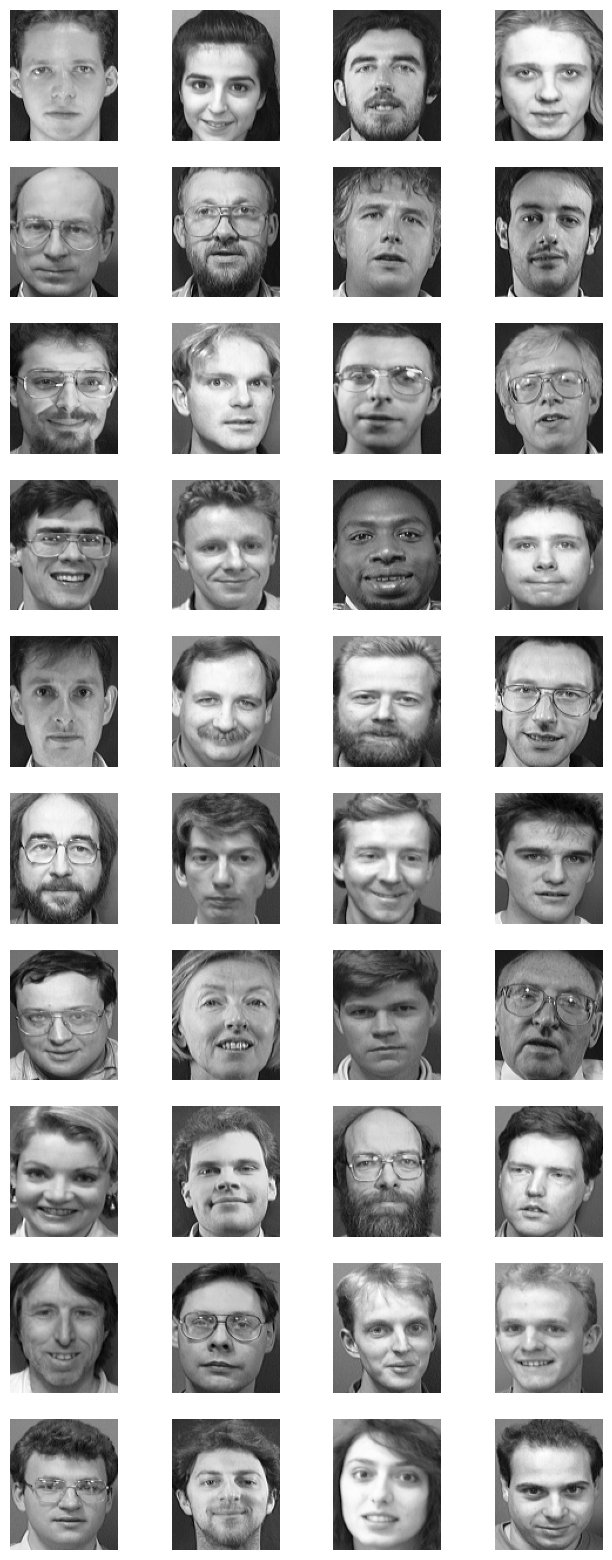

In [3]:
fig, axes = plt.subplots(10, 4, sharex=True, sharey=True, figsize=(8, 20))
faceimages = list(faces.values()) 
for i in range(40):
    axes[i // 4, i % 4].imshow(faceimages[i]["1.pgm"], cmap="gray") # displaying the image 1 for all subjects
    axes[i // 4, i % 4].axis('off')  # Turn off axis labels

plt.show()

In [4]:
face_shape = faces["s1"]["1.pgm"].shape
print(f"The shape of the any image: {face_shape}")

The shape of the any image: (112, 92)


In [5]:
subjects = list(faces.keys())
images_per_sub = list(faces["s1"].keys())
print(f"The number of subjects in the dataset {len(subjects)}")
print(f"The number of images per subject {len(images_per_sub)}")

The number of subjects in the dataset 40
The number of images per subject 10


In [47]:
# composing the face matrix 

face_matrix = list()
face_labels = list()

for key, value in faces.items():
    if key == "s40":
        continue # kept for testing 
    for sub_key, sub_value in value.items():
        if sub_key == "10.pgm": 
            continue # kept for testing 
        flatten_image = face_matrix.append(sub_value.flatten())
        face_labels.append(key) # add the label of the subject 

face_matrix = np.array(face_matrix)

In [7]:
print(face_matrix.shape) # M x L  (L --> the number of pixels per image,  M --> number of images)
# 39 + 10 = 49 left for testing   

(351, 10304)


In [8]:
pca = PCA().fit(face_matrix) # eigen_decomposition of square matrix ((face_matrix - mean_image).Transpose() @  (face_matrix - mean_image))
# row-wise PCAs   

In [9]:
sorted_eigen_values = np.sort(pca.explained_variance_ratio_)[::-1]
print(f"The number of principal components: {len(sorted_eigen_values)}")

The number of principal components: 351


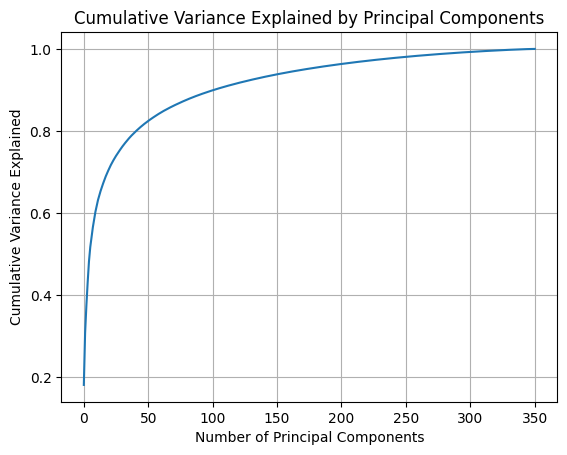

In [10]:
cumulative_variance = np.cumsum(sorted_eigen_values)
plt.plot(cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)

In [11]:
# let's assume that we will consider just 90 % of variance in the data, so will consider just first 101 principal components  
upto_index = np.where(cumulative_variance < 0.9)[0][-1] # the last one 
print(f"Up to index {upto_index}, we can get up to {cumulative_variance[upto_index]} of variance in the images") # nearly 90 % 

Up to index 100, we can get up to 0.8991953303384578 of variance in the images


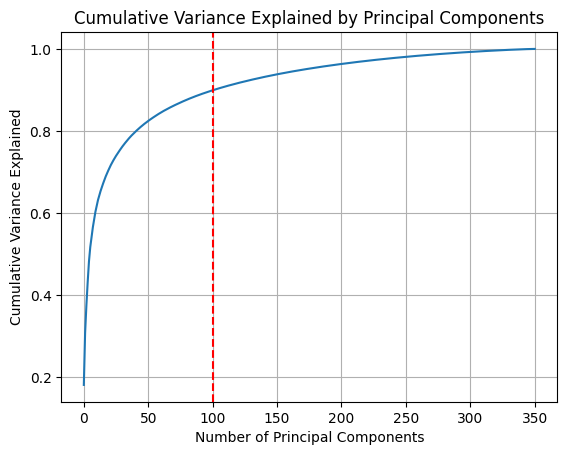

In [14]:
plt.plot(cumulative_variance)
plt.axvline(x= upto_index, color = "r", linestyle = "--")
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)

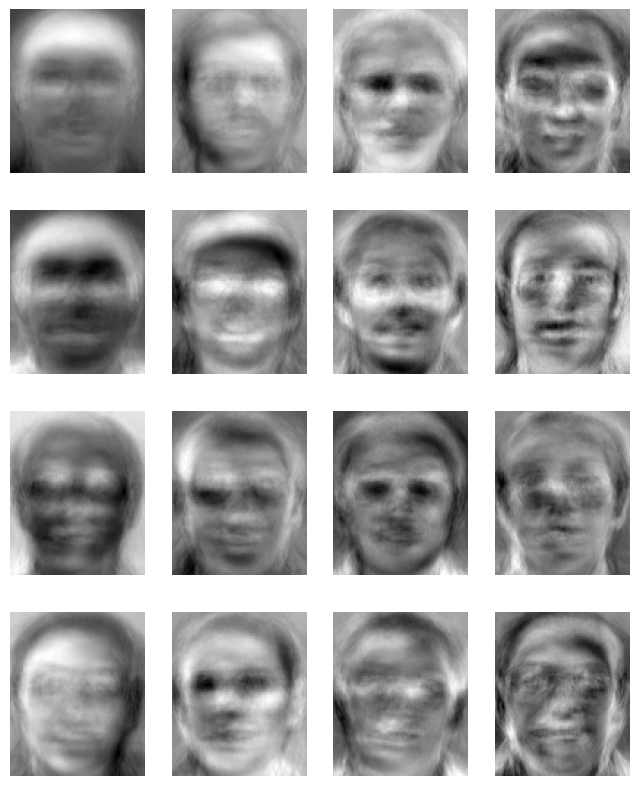

In [18]:
no_principal_components = upto_index + 1
eigen_faces = pca.components_[:no_principal_components]

ig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigen_faces[i].reshape(face_shape), cmap="gray")
    axes[i%4][i//4].axis("off")

In [29]:
weights = eigen_faces @ (face_matrix - pca.mean_).transpose()
weights.shape # row vector for each image in the face matrix which indicates the linear conbination of the PCAs what would generate that image.  

(101, 351)

In [53]:
def plot_match(query_image):
    query_image_weights = eigen_faces @ (query_image - pca.mean_).transpose()
    distances = np.linalg.norm(weights - query_image_weights, axis = 0 ) # compare row wise 
    best_match = np.argmin(distances)
    print("Best match %s with Euclidean distance %f" % (face_labels[best_match], distances[best_match]))
    # Visualize
    fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
    axes[0].imshow(query_image.reshape(face_shape), cmap="gray")
    axes[0].set_title("Query")
    axes[1].imshow(face_matrix[best_match].reshape(face_shape), cmap="gray")
    axes[1].set_title("Best match")
    axes[0].axis("off");
    axes[1].axis("off");

Best match s39 with Euclidean distance 1961.286573


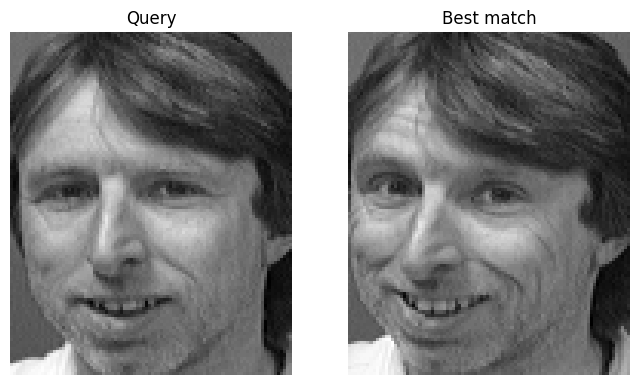

In [69]:
query_image = faces["s39"]["10.pgm"].reshape(1,-1)
plot_match(query_image)

Best match s30 with Euclidean distance 1276.469977


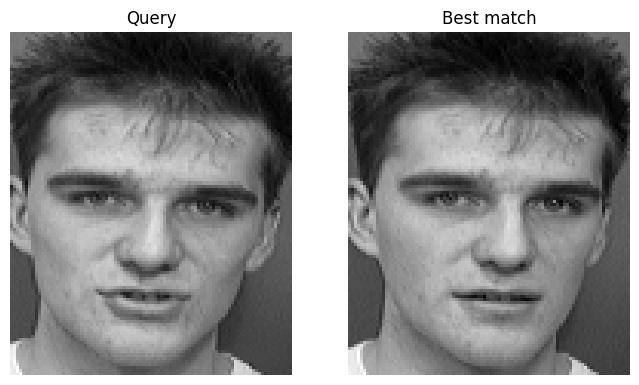

In [77]:
query_image = faces["s30"]["10.pgm"].reshape(1,-1) # the images of subject 40 is held out of the eigenfaces space
plot_match(query_image)

Best match s20 with Euclidean distance 1224.163684


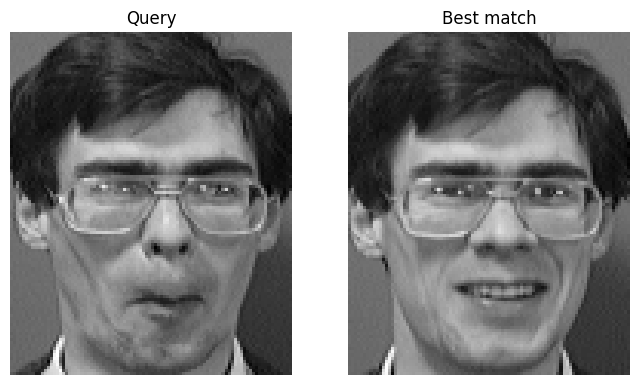

In [63]:
query_image = faces["s20"]["10.pgm"].reshape(1,-1) # the images of subject 40 is held out of the eigenfaces space
plot_match(query_image)

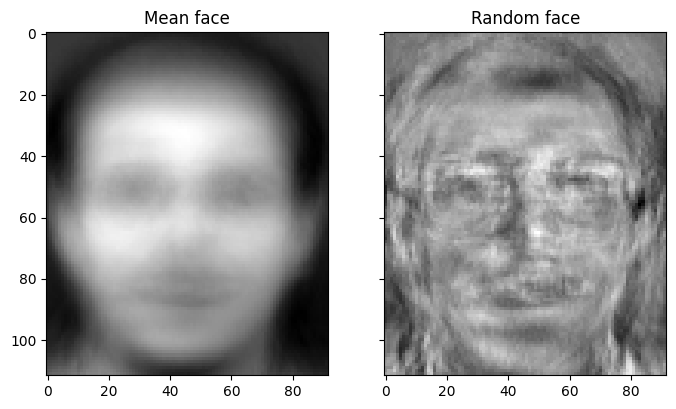

In [76]:
# Visualize the mean face and random face
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(pca.mean_.reshape(face_shape), cmap="gray")
axes[0].set_title("Mean face")
random_weights = np.random.randn(no_principal_components) * weights.std()
newface = random_weights @ eigen_faces + pca.mean_
axes[1].imshow(newface.reshape(face_shape), cmap="gray")
axes[1].set_title("Random face")
plt.show()